In [1]:
# !pip install tensorflow keras opencv-python


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import os

In [3]:
# Skapa en ImageDataGenerator med augmentering
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       # Slumpmässig rotation av bilder inom 10 grader
    width_shift_range=0.1,   # Slumpmässig horisontell förskjutning inom 10% av bildens bredd
    height_shift_range=0.1,  # Slumpmässig vertikal förskjutning inom 10% av bildens höjd
    shear_range=0.1,         # Slumpmässig skjuvning av bilder
    zoom_range=0.1,          # Slumpmässig zoom av bilder
    horizontal_flip=True,    # Slumpmässig horisontell flip
    fill_mode='nearest'      # Hur man fyller i nya pixlar efter en omvandling
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Ladda träningsdata med augmentering
train_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

# Ladda valideringsdata utan augmentering
validation_data = validation_datagen.flow_from_directory(
    'data/validation',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
model = Sequential()

# Första Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Andra Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tredje Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fjärde Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten för att konvertera 2D-data till 1D
model.add(Flatten())

# Fullt anslutet lager med 256 neuroner
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output Layer med 7 neuroner (en för varje känsla)
model.add(Dense(7, activation='softmax'))

# Kompilera modellen med en lägre inlärningshastighet
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Skapa en Early Stopping-callback
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Träna modellen med Early Stopping
history = model.fit(
    train_data,
    epochs=50,  # Sätt ett högre antal epochs, Early Stopping kommer att avsluta tidigare om det behövs
    validation_data=validation_data,
    callbacks=[early_stopper]
)

Epoch 1/50
  1/901 ━━━━━━━━━━━━━━━━━━━━ 30:59 2s/step - accuracy: 0.1562 - loss: 1.9480

C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - accuracy: 0.2253 - loss: 1.8525 - val_accuracy: 0.2583 - val_loss: 1.8406
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.2391 - loss: 1.8097 - val_accuracy: 0.2632 - val_loss: 1.7902
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.2496 - loss: 1.7897 - val_accuracy: 0.3152 - val_loss: 1.7293
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.2911 - loss: 1.7314 - val_accuracy: 0.3323 - val_loss: 1.6994
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.3350 - loss: 1.6733 - val_accuracy: 0.4178 - val_loss: 1.5423
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.3776 - loss: 1.5937 - val_accuracy: 0.4376 - val_loss: 1.4930
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.4070 - loss: 1.5357 - val_accuracy: 0.4725 - val_loss: 1.3956
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.4302 - loss: 1.4914 - val_accurac

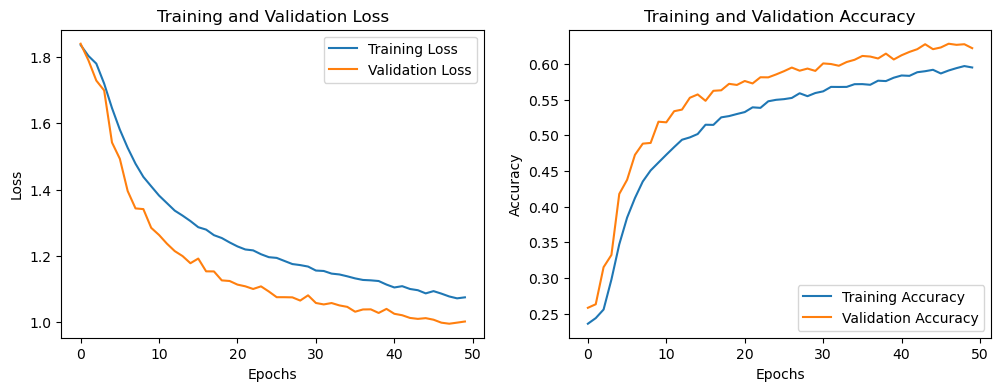

In [14]:
# Visualisera tränings- och valideringsförlust
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualisera tränings- och valideringsnoggrannhet
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Spara den tränade modellen
model.save('improved_emotion_detection_model.keras')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Ladda den förbättrade modellen
model = tf.keras.models.load_model('improved_emotion_detection_model.keras')

# Ordbok för att mappa klassindex till engelska känslor
emotion_dict = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Starta webbkameran
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0
        roi_gray = np.reshape(roi_gray, (1, 48, 48, 1))

        prediction = model.predict(roi_gray)
        emotion = np.argmax(prediction)

        cv2.putText(frame, emotion_dict[emotion], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    cv2.imshow('Emotion Detector', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()